In [1]:
from pathlib import Path
import random
import shutil
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import supervision as sv

from detection_labelling.config import LOCAL_DATA_DIR as DATA_DIR

In [2]:
def create_sampled_datasets(
    dataset_dir: Path,
    ds_info_dicts: List[Dict[str, Any]],
    n_samples: int,
    tmp_dir: Path = None
) -> Path:
    """
    Create a temporary directory with sampled images and annotations for comparison.
    
    Args:
        dataset_dir: Base directory containing the full dataset
        ds_info_dicts: List of dicts with model_name, img_folder, ann_folder
        n_samples: Number of samples to extract
        tmp_dir: Temporary directory path (will create if None)
    
    Returns:
        Path to the temporary directory containing sampled data
    """
    # Create temp directory
    if tmp_dir is None:
        tmp_dir = dataset_dir.parent / "tmp_comparison"
    
    tmp_dir.mkdir(exist_ok=True)
    
    # Get all image files from the first dataset (assuming all use same images)
    img_folder = dataset_dir / ds_info_dicts[0]["img_folder"]
    all_image_files = list(img_folder.glob("*.jpg")) + list(img_folder.glob("*.png"))
    
    if len(all_image_files) < n_samples:
        print(f"Warning: Only {len(all_image_files)} images available, using all of them")
        n_samples = len(all_image_files)
    
    # Random sample without fixed seed
    sampled_images = random.sample(all_image_files, n_samples)
    print(f"Selected {len(sampled_images)} random images for comparison")
    
    # Create images directory in tmp and copy sampled images
    tmp_images_dir = tmp_dir / "images"
    tmp_images_dir.mkdir(exist_ok=True)
    
    for img_path in sampled_images:
        shutil.copy2(img_path, tmp_images_dir / img_path.name)
    
    # For each model, create annotation directory and copy corresponding annotations
    for ds_dict in ds_info_dicts:
        model_name = ds_dict["model_name"]
        ann_folder = ds_dict["ann_folder"]
        
        # Create annotation directory for this model
        tmp_ann_dir = tmp_dir / f"annotations_{model_name}"
        tmp_ann_dir.mkdir(exist_ok=True)
        
        source_ann_dir = dataset_dir / ann_folder
        
        # Copy corresponding annotation files
        copied_count = 0
        for img_path in sampled_images:
            # Get corresponding annotation file (.xml)
            ann_filename = img_path.stem + ".xml"
            source_ann_path = source_ann_dir / ann_filename
            
            if source_ann_path.exists():
                shutil.copy2(source_ann_path, tmp_ann_dir / ann_filename)
                copied_count += 1
            else:
                print(f"Warning: No annotation found for {img_path.name} in {model_name}")
        
        print(f"Copied {copied_count}/{len(sampled_images)} annotations for {model_name}")
    
    return tmp_dir

In [13]:
dataset_dir = DATA_DIR / "raw/cctv_frames/repeated"
n_samples = 100

In [14]:
ds_info_dicts = [
    {"model_name": "yolov8m", "img_folder": "images", "ann_folder": "annotations_oob_yolov8m"},
    {"model_name": "yolov8m_v1_1", "img_folder": "images", "ann_folder": "annotations_oob"},
]

# Create sampled dataset
tmp_dir = create_sampled_datasets(
    dataset_dir=dataset_dir,
    ds_info_dicts=ds_info_dicts,
    n_samples=100,  # Adjust this number as needed
)

# Now load the sampled datasets
for ds_dict in ds_info_dicts:
    model_name = ds_dict["model_name"]

    ds = sv.DetectionDataset.from_pascal_voc(
        images_directory_path=tmp_dir / "images",
        annotations_directory_path=tmp_dir / f"annotations_{model_name}",
    )

    ds_dict["ds"] = ds
    print(f"Loaded {len(ds)} samples for {model_name}")

print(f"Temporary comparison data saved in: {tmp_dir}")

Selected 100 random images for comparison
Copied 100/100 annotations for yolov8m
Copied 100/100 annotations for yolov8m_v1_1
Loaded 100 samples for yolov8m
Loaded 100 samples for yolov8m_v1_1
Temporary comparison data saved in: D:\Documentos\Data\projects\cyclist_census\data\detection\raw\cctv_frames\tmp_comparison


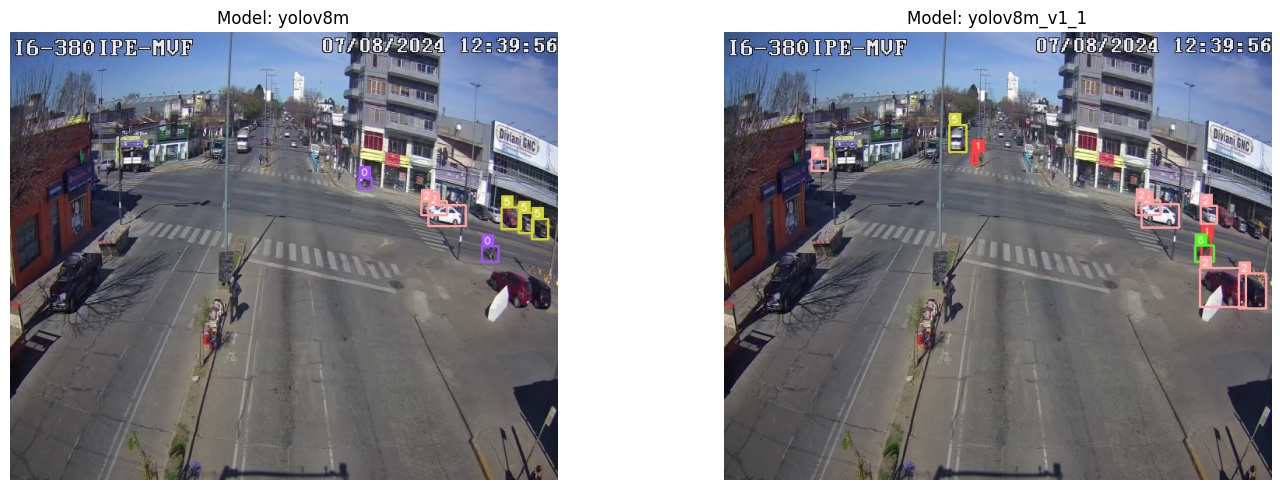

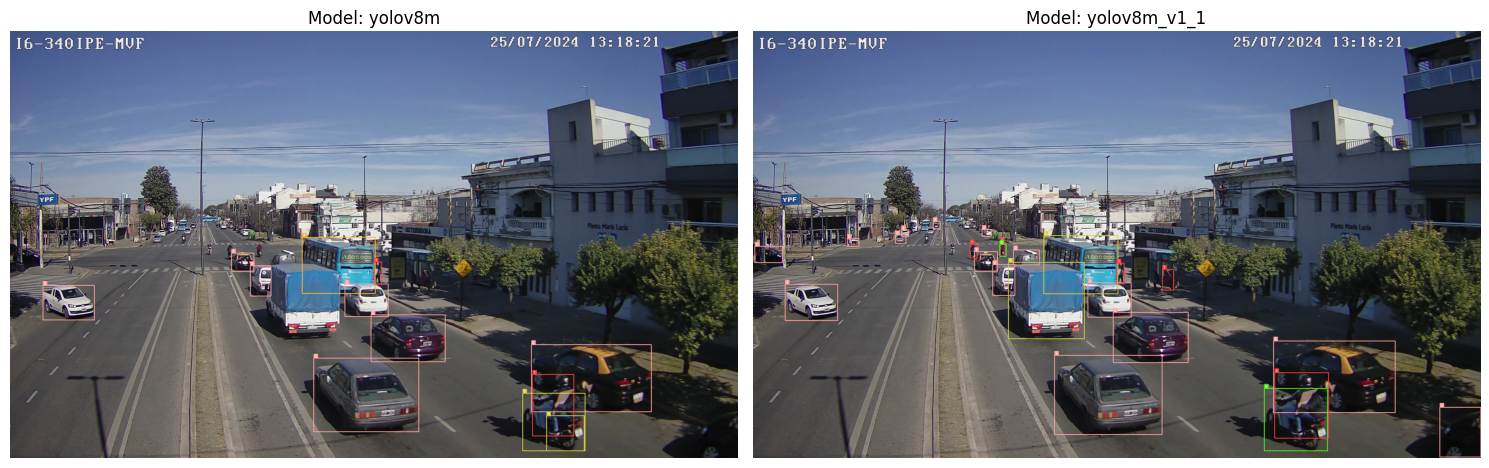

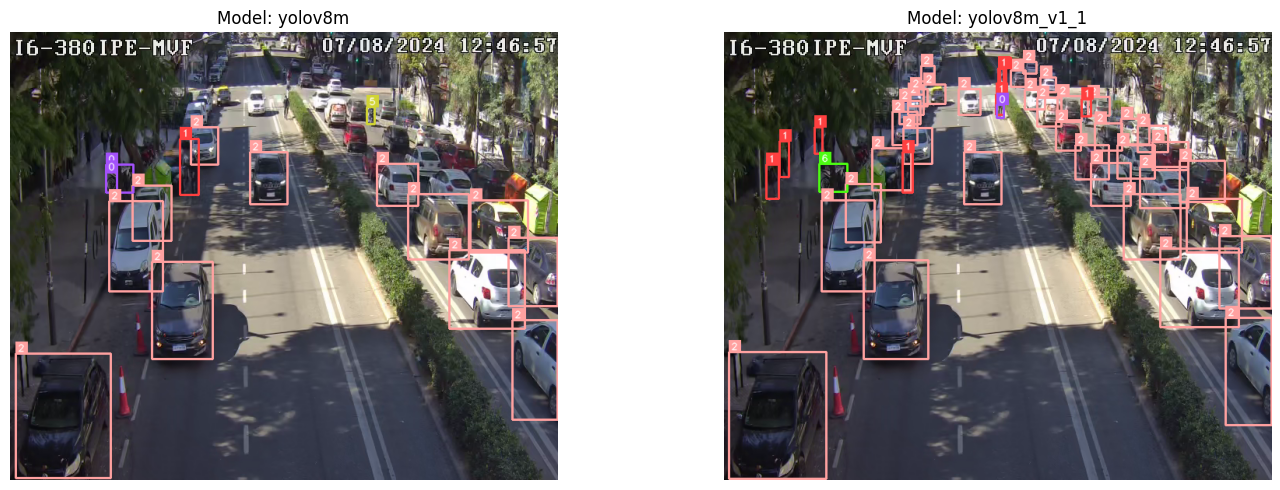

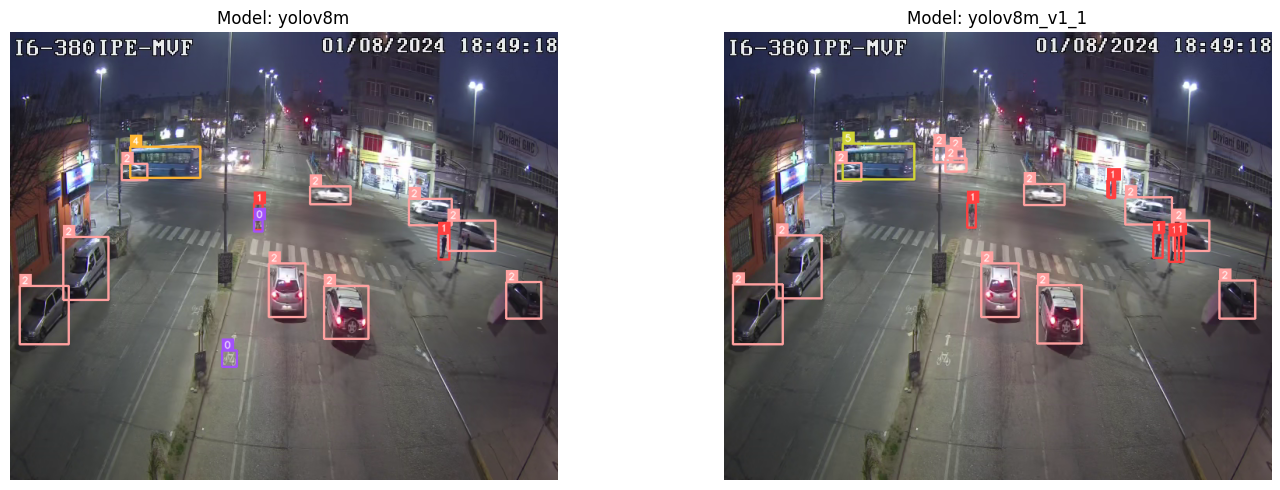

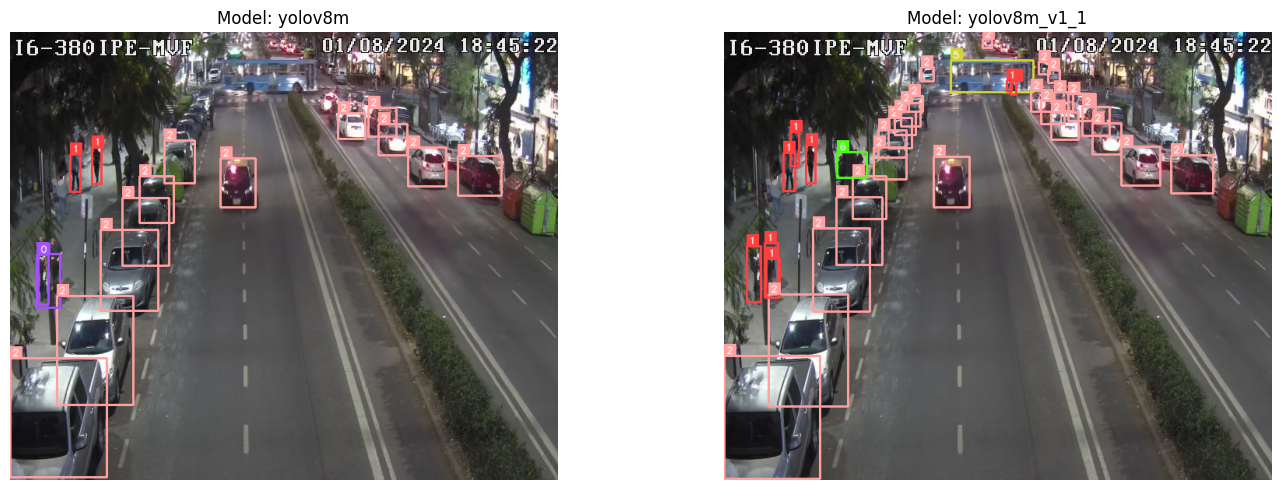

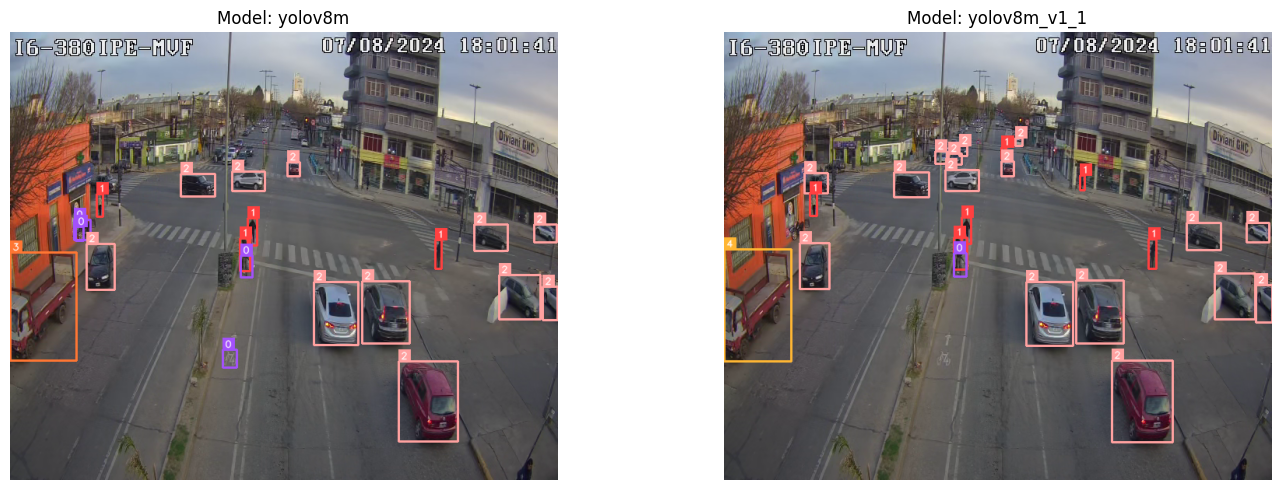

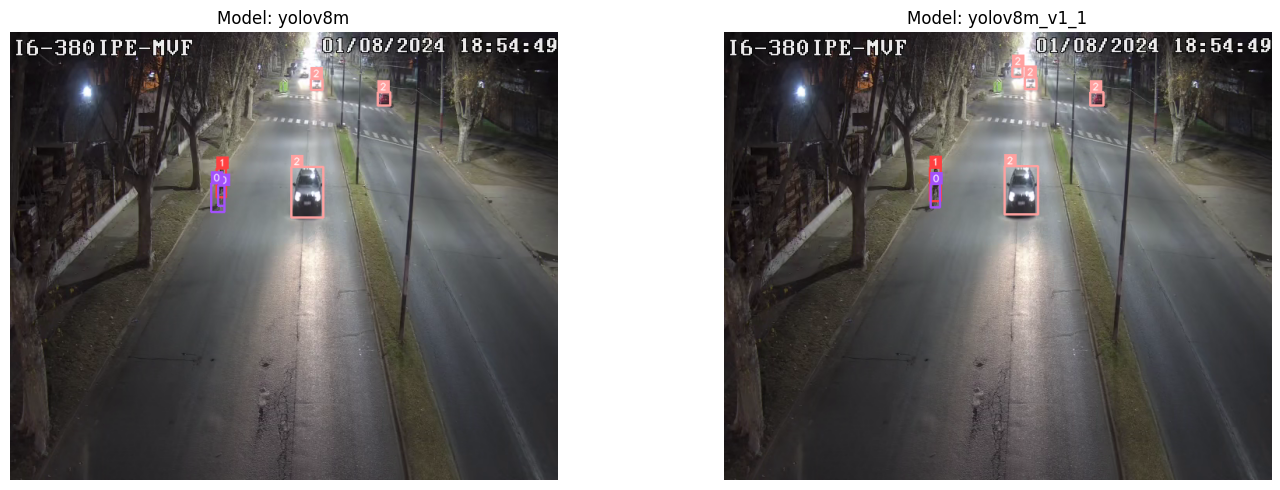

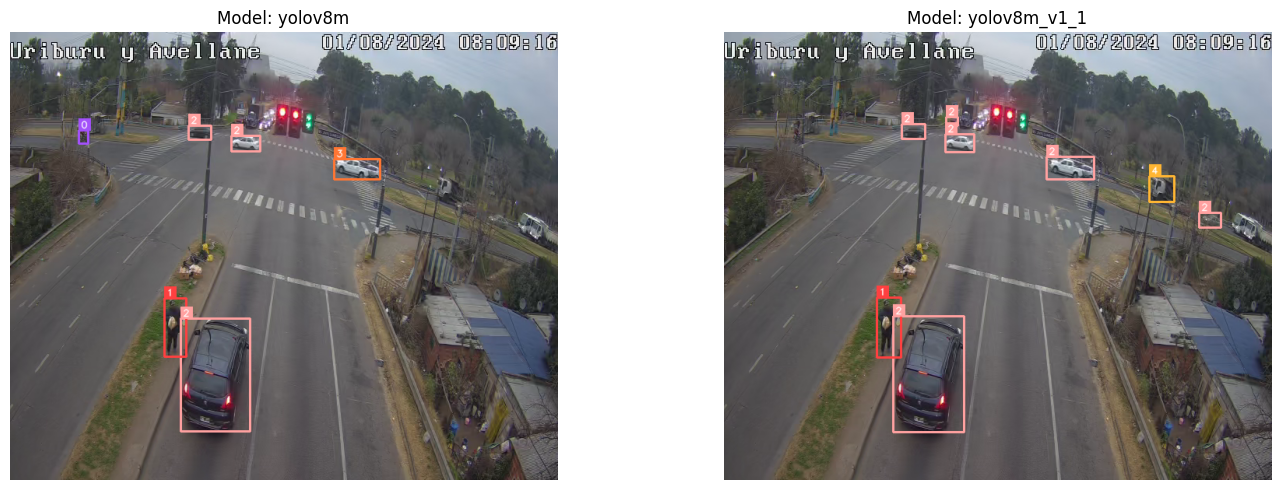

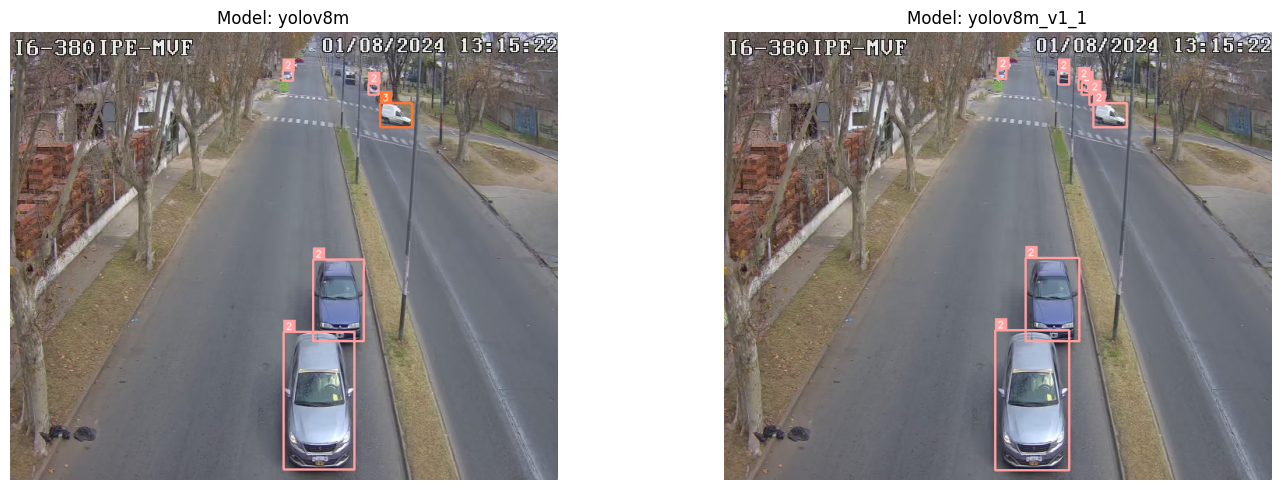

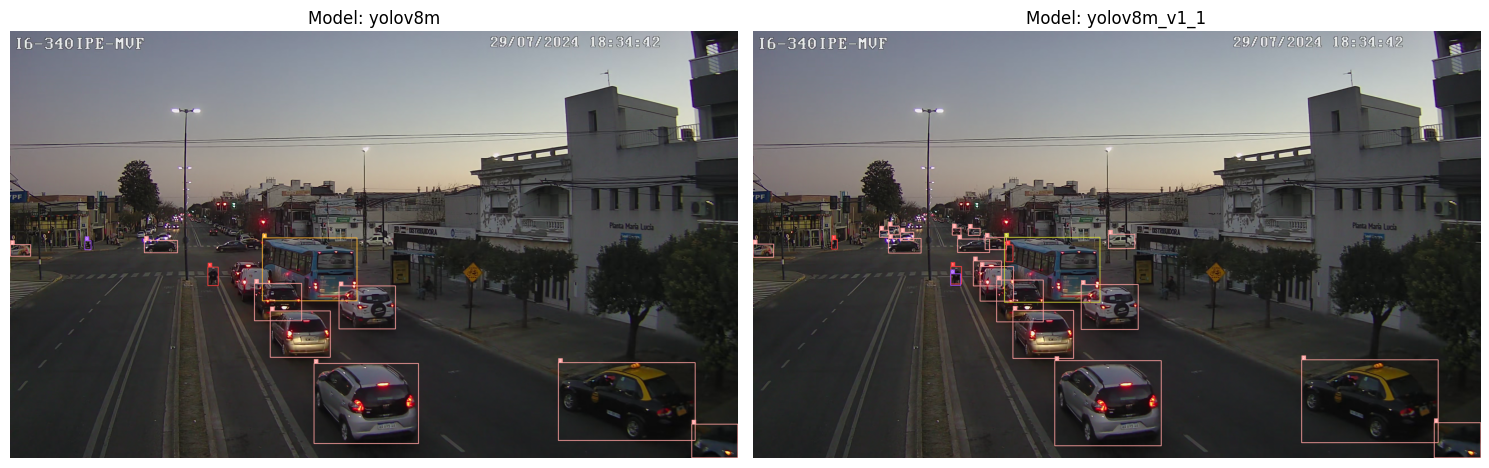

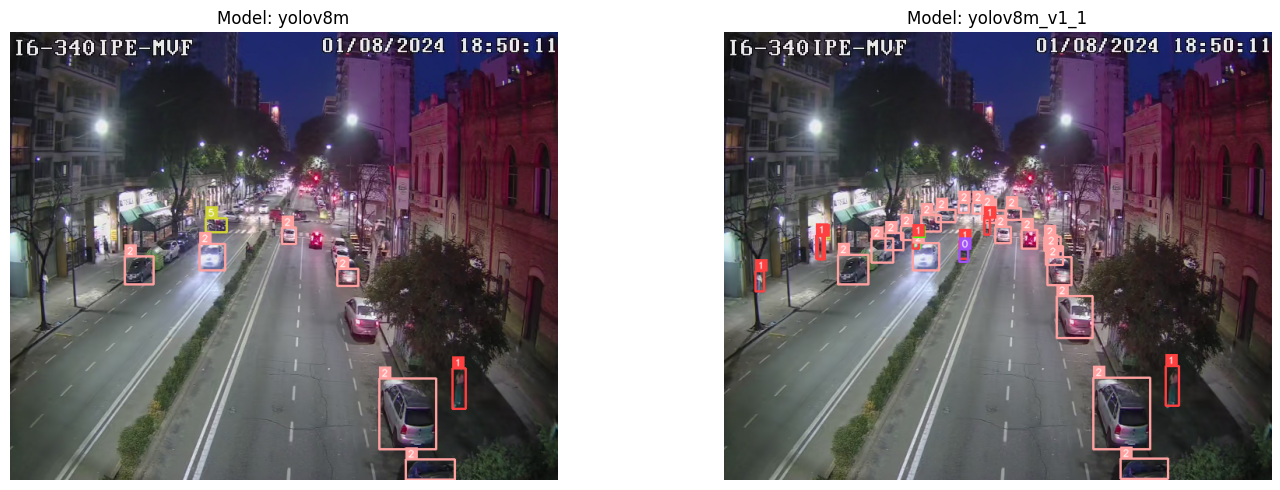

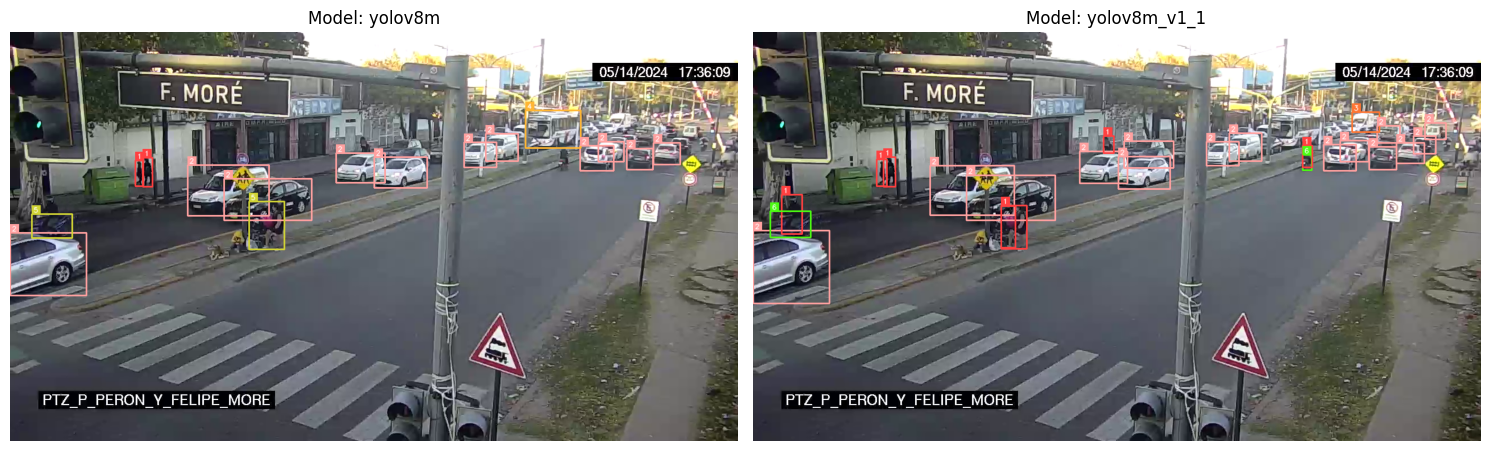

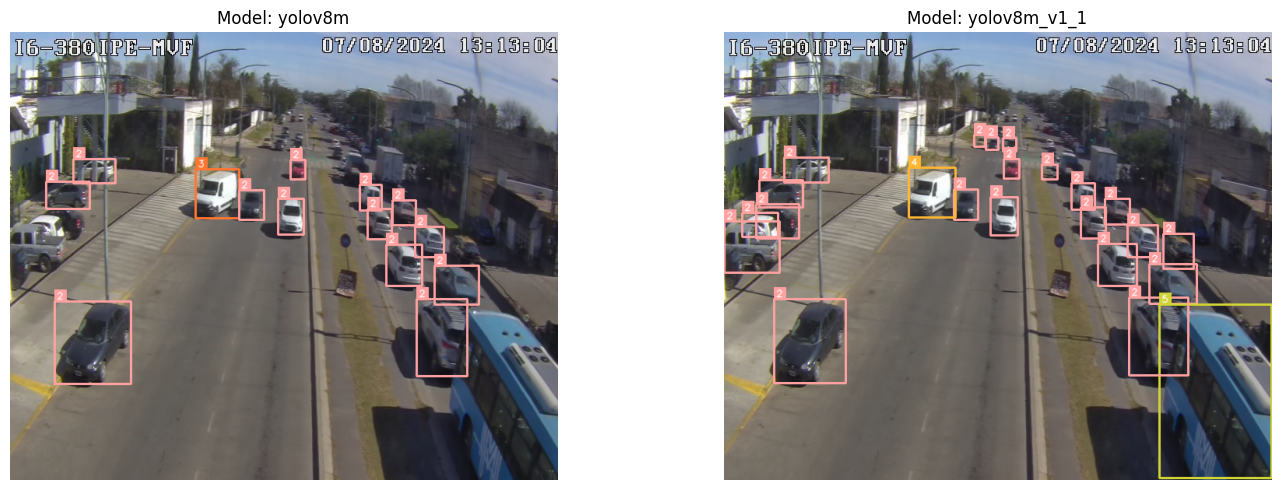

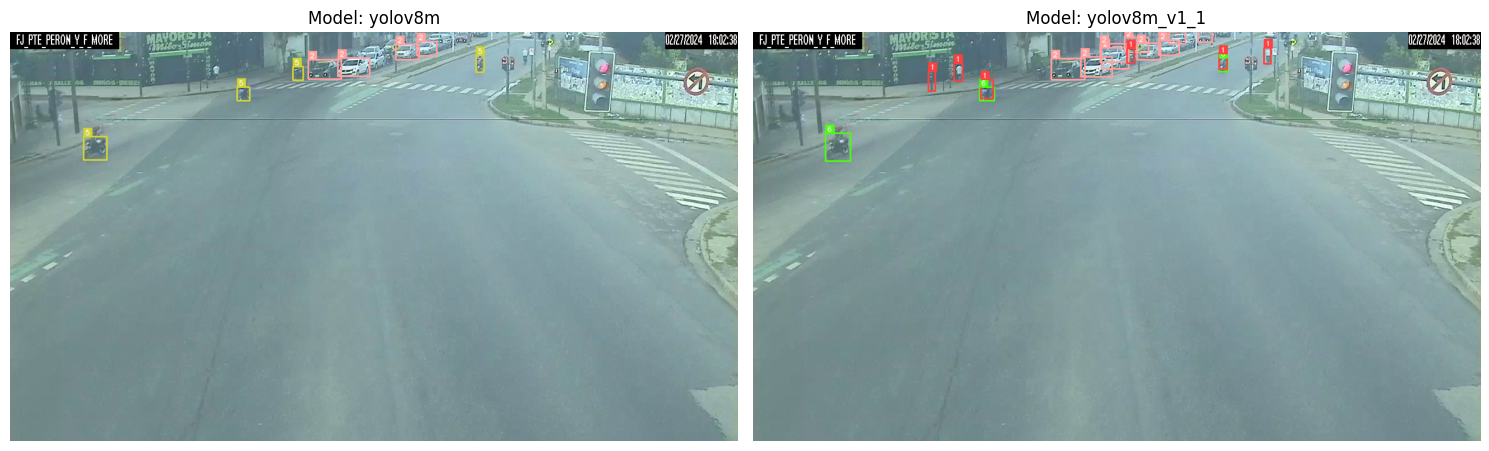

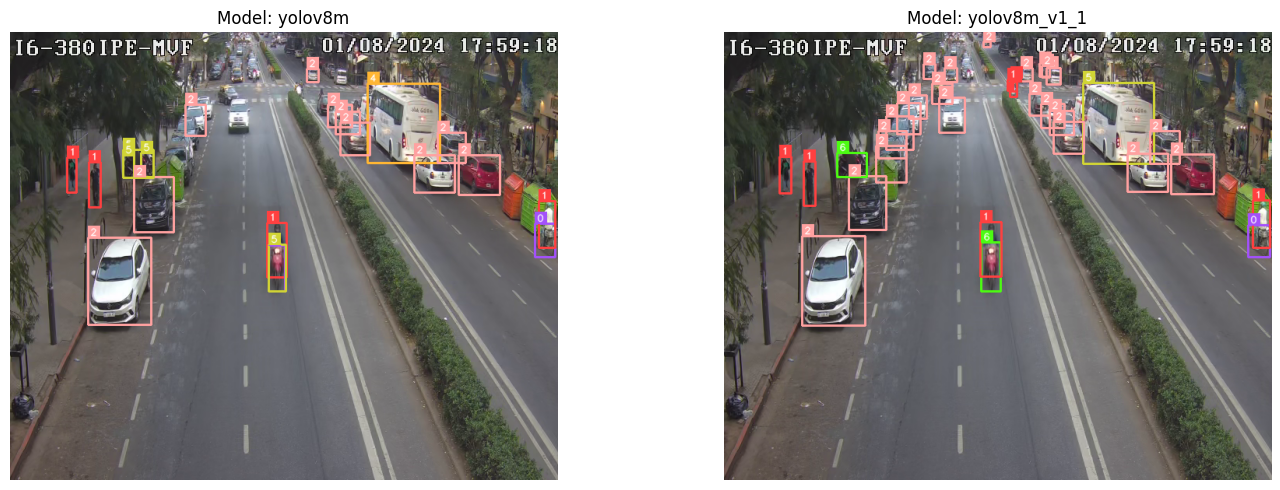

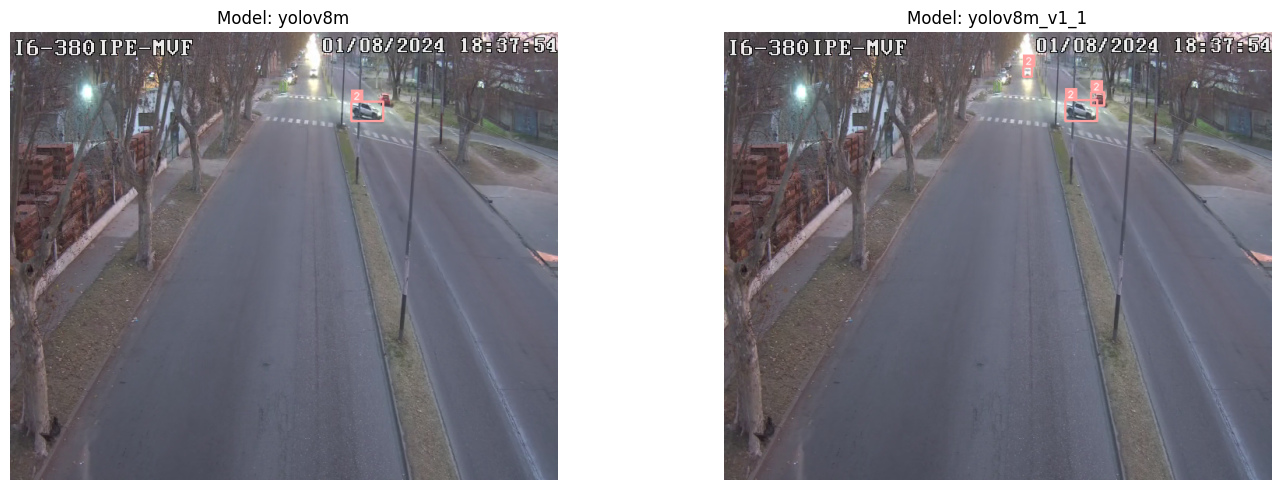

In [17]:
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_scale=0.4, text_padding=3)

images_ids = np.random.randint(low=0, high=n_samples, size=16)

for idx in images_ids:
    fig, axes = plt.subplots(1, len(ds_info_dicts), figsize=(15, 5))

    for ax, ds_dict in zip(axes, ds_info_dicts):
        _, img, ann = ds_dict["ds"][idx]

        annotated_image = img.copy()

        labels = [f"{class_id}" for _, _, _, class_id, _, _ in ann]

        annotated_image = box_annotator.annotate(annotated_image, ann)
        annotated_image = label_annotator.annotate(annotated_image, ann, labels)

        ax.imshow(annotated_image[:, :, ::-1])
        ax.axis("off")  # Remove axes
        ax.set_title(f"Model: {ds_dict['model_name']}")

    plt.tight_layout()
    plt.show()

Remove tmp folder and its content

In [18]:
if tmp_dir.exists():
    shutil.rmtree(tmp_dir)
    print(f"Removed temporary directory: {tmp_dir}")
else:
    print(f"Temporary directory not found: {tmp_dir}")

Removed temporary directory: D:\Documentos\Data\projects\cyclist_census\data\detection\raw\cctv_frames\tmp_comparison
